_Energy_ 

\begin{equation*}
H(x, p_x, t) = \frac{1}{2} (p_x^2 - x^2 + \frac{1}{2} x^4)
\end{equation*}

_Vector field_ whith _time-dependent harmonic forcing_

\begin{align*}
 \dot{x} &= \frac{\partial H}{\partial p_x} = f_1(x, p_x) = p_x \\
 \dot{p}_x &= -\frac{\partial H}{\partial x} + + \eta(t) = f_2(x, p_x) = x - x^3 + \eta(t)
 \end{align*}
 
where

\begin{align*}
\eta(t) = A \cdot sin(\omega t)
\end{align*}

with $A$ and $\omega$ the amplitude and the frequency of the perturbation.

* Provide files with fine discretisation and rough.

Define grid for sampling of data-points

* We require the spatial domain of the vector field to be larger than the domain where the LD is computed - otherwise this can lead to boarder effects on the interpolation

In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pylds.base import perturb_field
from pylds.vector_fields import Duffing1D, forcing

# Discretise vector field

## Method: `discretise_vector_field`

In [2]:
def discretise_vector_field(sample_time_points, sample_coords, vector_field):
    """
    Returns a 1-dimensional array of 2-D vector field values evaluated on a 2D grid of points 
    for a 1-dimensional array of time-points. 

    Parameters
    ----------
    sample_time_points: 1d array,
        time-points in a sample time-interval.
    
    sample_coords : list of ndarrays,
        [x,y] contain coordinates.

    vector_field : function,
        Function/vector field to be discretised.

    Returns
    -------
    vector_field_data : ndarray, len(t),
        Array of function/vector field values.
    """
    x, y = sample_coords
    X,Y = np.meshgrid(x,y,indexing='xy')
    sample_xy_points = np.column_stack([X.ravel(),Y.ravel()])
    
    vector_field_data = [vector_field(t, sample_xy_points) for t in sample_time_points]

    return np.array(vector_field_data)

## Method: `generate_vector_field_data`

In [6]:
def generate_vector_field_data(sample_time_points, sample_coords, vector_field, filename):
    """
    Saves 2-dimensional array of function (vector field) values on a grid of points to 
    pylds/vector_field_files/filename.hdf5. File format fixed to HDF5 by default.

    Note that storage fails if x_axis and y_axis in sample_coords are not the same length.

    Parameters
    ----------
    sample_time_points: 1d array,
        time-points in a sample time-interval.
    
    sample_coords : list of ndarrays,
        [x,y] contain coordinates.

    vector_field : function,
        Function/vector field to be discretised.

    filename : string
        Name of hdf5 file to be saved.
    """

    vector_field_data = discretise_vector_field(sample_time_points, sample_coords, vector_field)
    
    dirname = 'pylds/vector_field_files'
    filepath = os.path.join(dirname, filename+'.hdf5')
    hf = h5py.File(filepath,'w')
    
    hf.create_dataset('sample_time', data=np.array(sample_time_points).astype('float64'))
    hf.create_dataset('sample_coords', data=np.array(sample_coords).astype('float64'))
    hf.create_dataset('vector_field_data', data=vector_field_data.astype('float64'))
    
    hf.close()

<span style="color:red">__CAVEATS__</span>

* Storage fails if `x_axis` and `y_axis` in `sample_coords` are not the same length

## TEST: Sample vector field data

__FIRST__ Define sampling spatial grid and time interval to collect vector field data frames

In [3]:
x_min, x_max, Nx = [-2, 2, 40]
y_min, y_max, Ny = [-1.5, 1.5, 40]
t_min, t_max, Nt = [0, 10, 50]

x_axis = np.linspace(x_min,x_max,Nx)
y_axis = np.linspace(y_min,y_max,Ny)
t_axis = np.linspace(t_min,t_max,Nt)

vector_field_original = Duffing1D
vector_field = perturb_field(vector_field_original, forcing)

__SECOND__ Call function to store vector field data frame into a variable

In [4]:
vector_field_data = discretise_vector_field(t_axis, [x_axis, y_axis], vector_field)

__THIRD__ Plot single vector field frame for a particular time-point

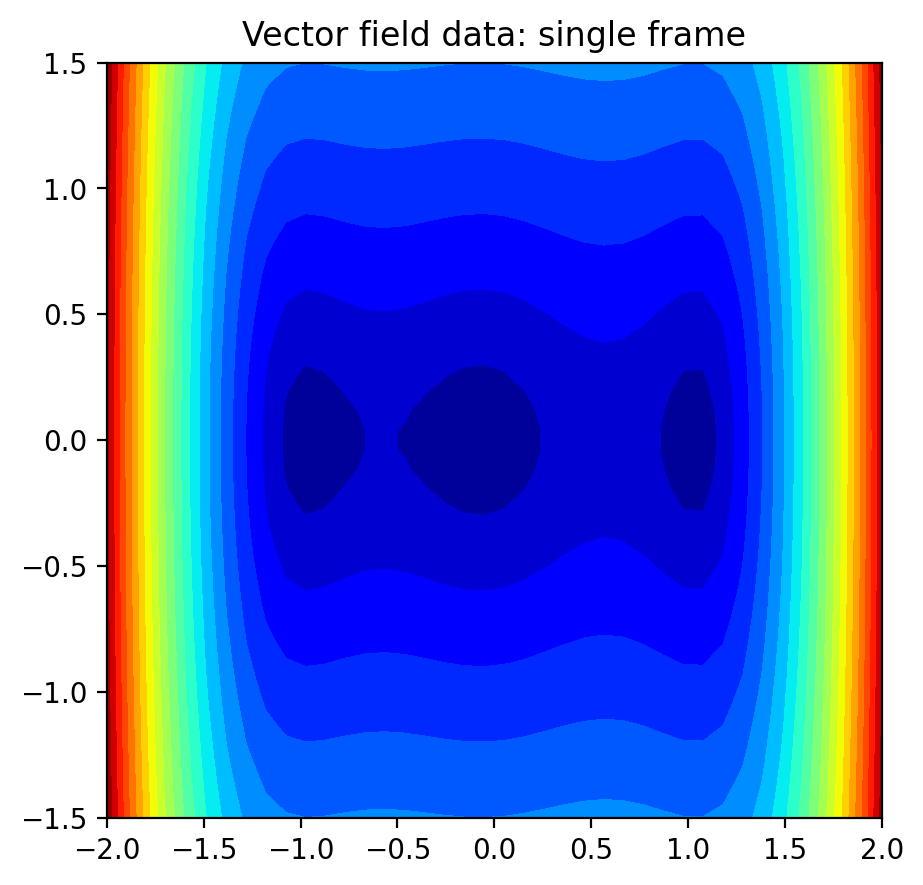

In [5]:
fig,ax = plt.subplots(1,1,figsize=(5,5),dpi=200,sharex=True,sharey=True)

t_idx = 5
C = np.linalg.norm(vector_field_data[t_idx],axis=1).reshape(len(x_axis), len(y_axis))

ax.contourf(x_axis, y_axis, C, cmap='jet',levels=20)
ax.set_title("Vector field data: single frame")

plt.show()

## TEST: Sample data and store into file

In [7]:
filename = 'Duffing_perturbed_vector_field_data'
generate_vector_field_data(t_axis, [x_axis, y_axis], vector_field, filename)

Extract data from HDF5 format file

In [8]:
filename = 'Duffing_perturbed_vector_field_data'
hf = h5py.File('pylds/vector_field_files/'+filename+'.hdf5','r')
time = np.array(hf.get('sample_time'))
coords = np.array(hf.get('sample_coords'))
vector_field_data_file = np.array(hf.get('vector_field_data'))
hf.close()

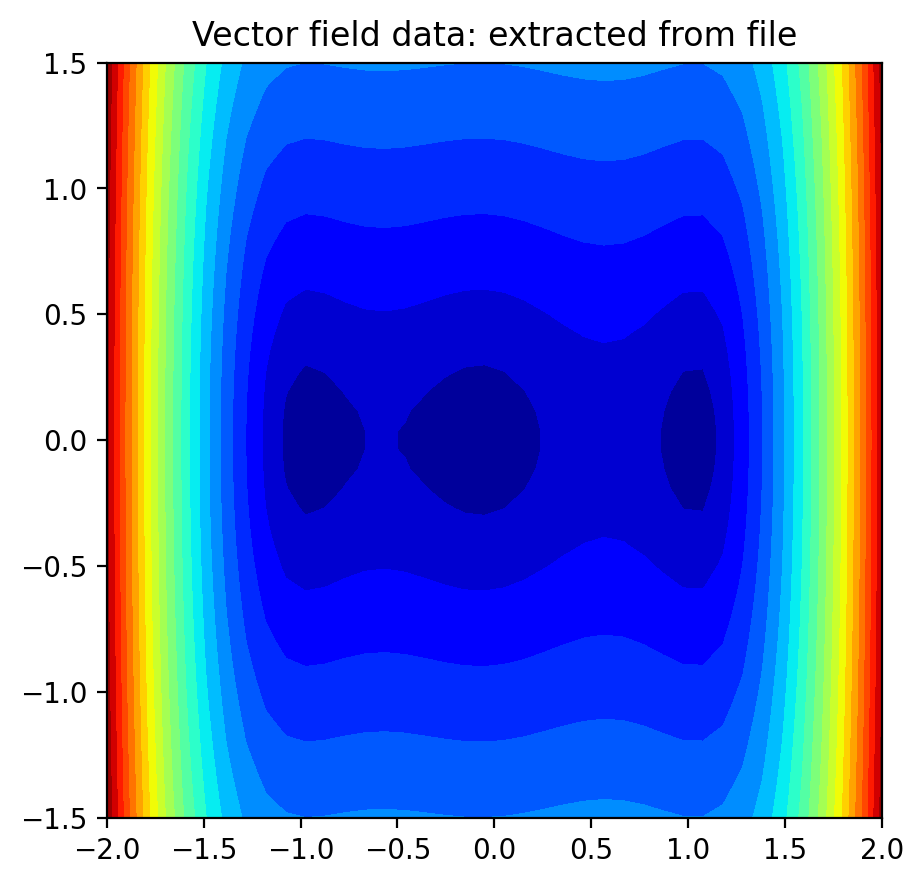

In [9]:
fig,ax = plt.subplots(1,1,figsize=(5,5),dpi=200,sharex=True,sharey=True)

t_idx = 5
x_axis, y_axis = coords
C = np.linalg.norm(vector_field_data_file[t_idx],axis=1).reshape(len(x_axis), len(y_axis))

ax.contourf(x_axis, y_axis, C, cmap='jet',levels=20)
ax.set_title("Vector field data: extracted from file")

plt.show()

# Fit vector field data

## TEST: Time-interpolation

In [10]:
from scipy import interpolate

In [11]:
vector_field_t_interp = lambda t: interpolate.interp1d(time, vector_field_data_file.T, kind='cubic')(t).T

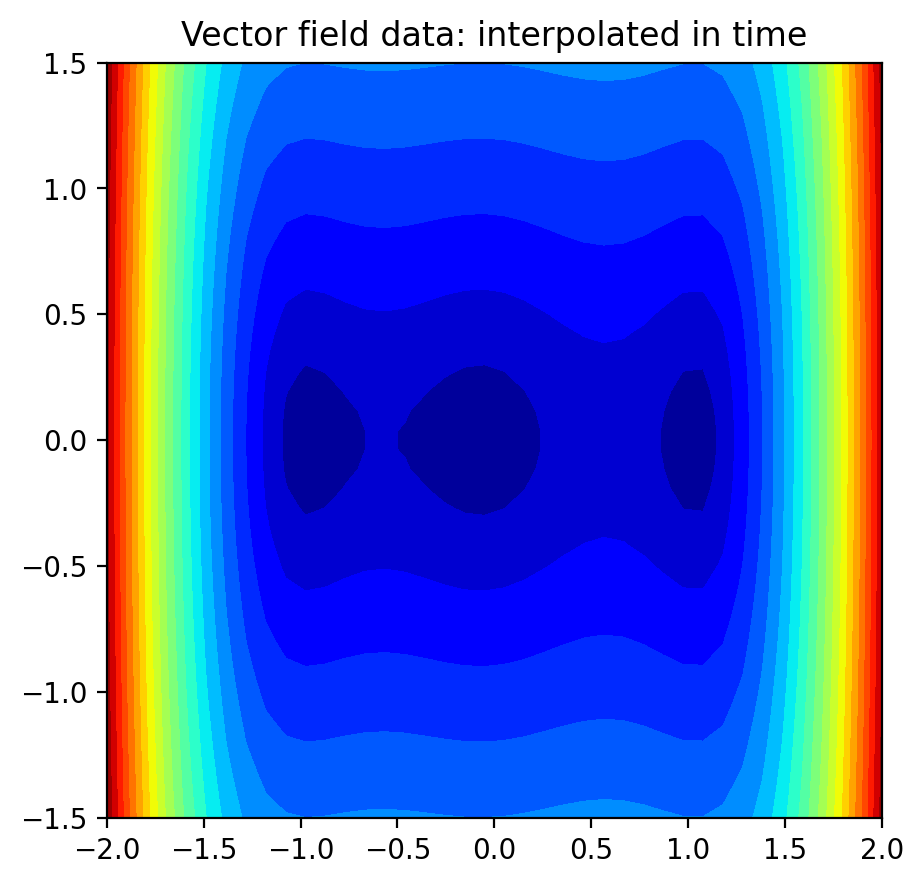

In [12]:
fig,ax = plt.subplots(1,1,figsize=(5,5),dpi=200,sharex=True,sharey=True)

t_idx = 5
C = np.linalg.norm(vector_field_t_interp(time[t_idx]),axis=1).reshape(len(coords[0]), len(coords[1]))

ax.contourf(coords[0], coords[1], C, cmap='jet',levels=20)
ax.set_title("Vector field data: interpolated in time")

plt.show()

## Method: `fit_vector_field`

In [13]:
from scipy.interpolate import interp1d, interp2d

def fit_vector_field(filename):
    """
    Returns a 2-dimensional function (vector field) fitted to 
    data located in pylds/vector_field_files/filename.hdf5.

    Parameters
    ----------
    filename : string
        Name of file containing data:
        sample_time_points: 1d array,
            time-points in a sample time-interval.

        sample_coords : list of ndarrays,
            [x,y] contain coordinates.
            
        vector_field_data : ndarray, len(t),
            Array of function/vector field values.
    
    Returns
    -------
    vector_field_interpolated : function
        returns a vector field function to be evaluated at (t, u).
        with t a float and u (n,2)-array.
    """
    hf = h5py.File('pylds/vector_field_files/'+filename+'.hdf5','r')
    #extract data
    time = np.array(hf.get('sample_time'))
    coords = np.array(hf.get('sample_coords'))
    data = np.array(hf.get('vector_field_data'))
    
    hf.close()
    
    def vector_field_wrap(v, u):
        return v(u[0],u[1])
    
    def vector_field_interpolated(t, u):
        #interpolate data in time 
        v_interp_t = lambda t: interp1d(time, data.T, kind='cubic')(t).T
        
        #evaluate components of interpolated field at t
        x, y = coords
        z_x = v_interp_t(t).T[0].reshape(len(x), len(y))
        z_y = v_interp_t(t).T[1].reshape(len(x), len(y))
        
        #interpolate above data in space
        v_x = interp2d(x, y, z_x, kind='cubic')
        v_y = interp2d(x, y, z_y, kind='cubic')
        
        #evaluate components of interpolated field at u
        v_x_eval = np.array(list(map(lambda a: vector_field_wrap(v_x, a), u)))
        v_y_eval = np.array(list(map(lambda a: vector_field_wrap(v_y, a), u)))
        
        return np.column_stack([v_x_eval, v_y_eval])
    
    return vector_field_interpolated

In [14]:
filename = 'Duffing_perturbed_vector_field_data'
discretised_vector_field = fit_vector_field(filename)

## TEST: Compare fitted and analytical vector fields

In [22]:
import matplotlib.pyplot as plt

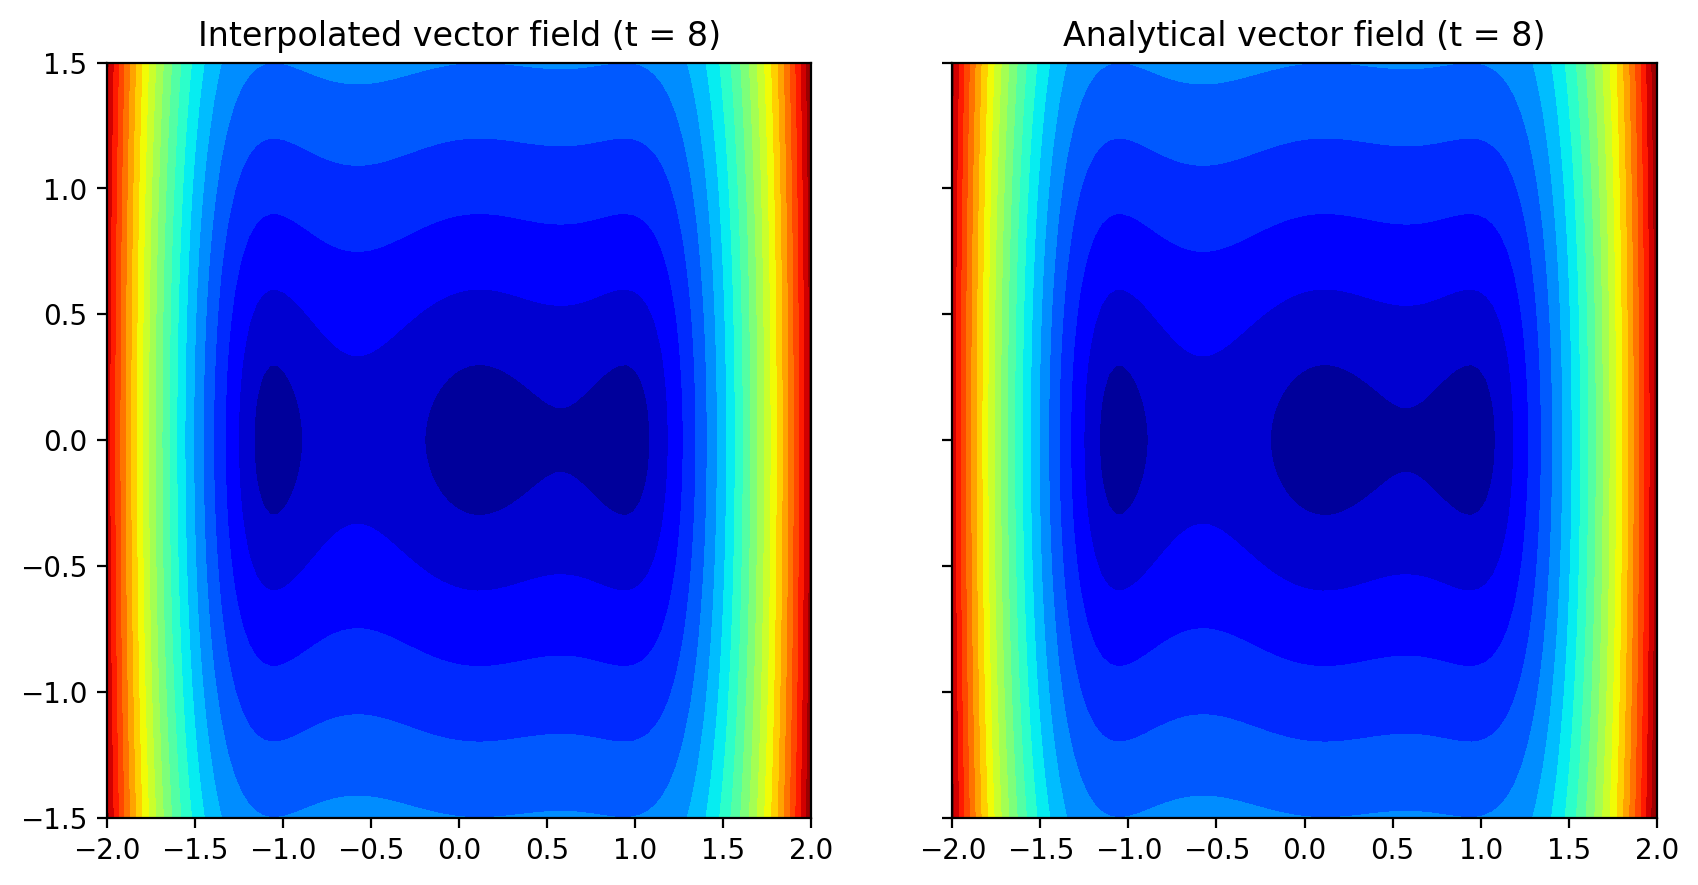

In [16]:
fig,ax = plt.subplots(1,2,figsize=(10,5),dpi=200,sharex=True,sharey=True)

# Mesh parameters
xp_min,xp_max = [-2, 2]
yp_min,yp_max = [-1.5, 1.5]
Nxp, Nyp = [100, 100]
xp = np.linspace(xp_min,xp_max, Nxp)
yp = np.linspace(yp_min,yp_max, Nyp)

X,Y = np.meshgrid(xp, yp)
u = np.column_stack([X.ravel(), Y.ravel()])
######################################
t0 = 8
######################################
# DATA-FITTED vector field
C_dis = np.linalg.norm(discretised_vector_field(t0, u), axis=1)

ax[0].contourf(xp, yp, C_dis.reshape(len(xp),len(yp)), cmap='jet', levels=20)
ax[0].set_title("Interpolated vector field (t = "+str(t0)+")")
######################################
# ORGINAL non-autonomous vector field
C = np.linalg.norm(vector_field(t0, u), axis=1)

ax[1].contourf(xp, yp, C.reshape(len(xp),len(yp)), cmap='jet', levels=20)
ax[1].set_title("Analytical vector field (t = "+str(t0)+")")
######################################
plt.show()

# Compute Lagrangian Descriptors

In [17]:
from pylds.base import compute_lagrangian_descriptor
from pylds.tools import draw_all_lds

In [18]:
# Integration parameters
tau = 8

# LDp, p-value
p_value = 0.5

# Mesh parameters
x_min,x_max = [-1.6, 1.6]
y_min,y_max = [-1, 1]
Nx, Ny = [100, 100]

In [19]:
grid_parameters = [(x_min, x_max, Nx), (y_min, y_max, Ny)]

In [23]:
LD_forward_analytical_v = compute_lagrangian_descriptor(grid_parameters, vector_field, tau, p_value)
LD_forward_discretised_v = compute_lagrangian_descriptor(grid_parameters, discretised_vector_field, tau, p_value)

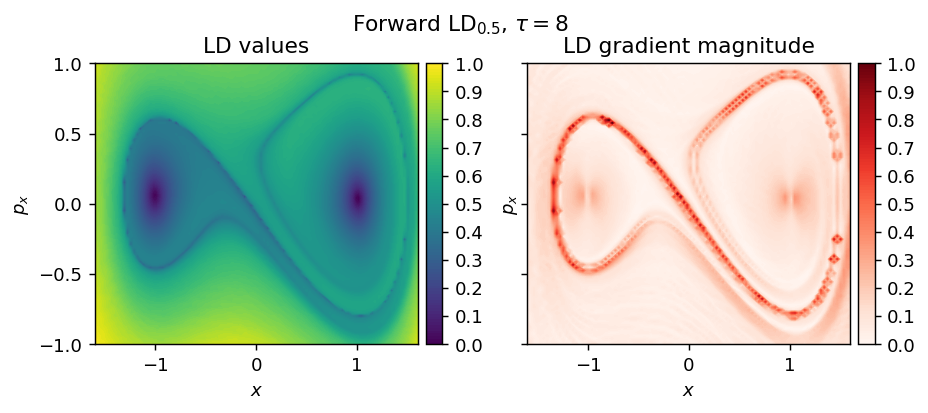

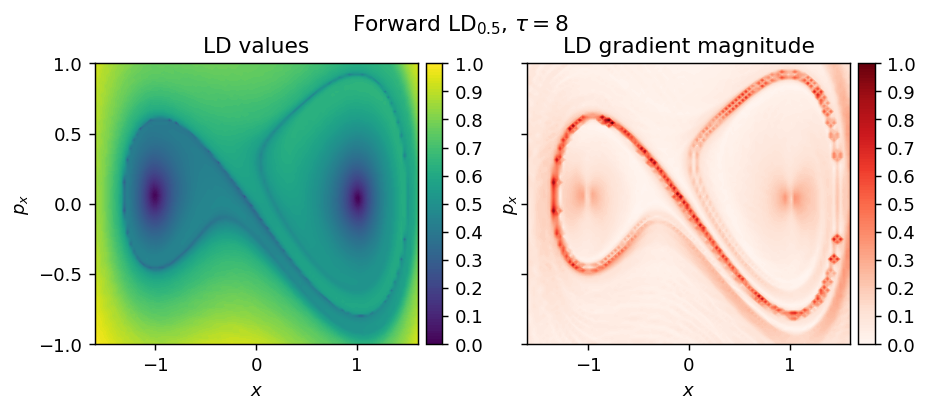

In [24]:
figs0 = draw_all_lds(LD_forward_analytical_v, [], grid_parameters, tau, p_value, interactive=False)
figs1 = draw_all_lds(LD_forward_discretised_v, [], grid_parameters, tau, p_value, interactive=False)

# Implementation

# TEST: Simplified execution 

In [1]:
import numpy as np
from pylds.vector_fields import Duffing1D, forcing
from pylds.testing_scripts import generate_vector_field_data
from pylds.base import perturb_field, fit_vector_field, compute_lagrangian_descriptor
from pylds.tools import draw_all_lds

In [2]:
# Integration parameters
tau = 8

# LDp, p-value
p_value = 0.5

# Mesh parameters
ax1_min, ax1_max = [-1.6, 1.6]
ax2_min, ax2_max = [-1, 1]
N1, N2 = [100, 100]

In [3]:
grid_parameters = [(ax1_min, ax1_max, N1), (ax2_min, ax2_max, N2)]

In [7]:
# define sample spatial grid and interval
x = np.linspace(-2, 2, 40)
y = np.linspace(-1.5, 1.5, 40)
t = np.linspace(-10, 10, 50)

# analytical vector field (non-autonomous)
vector_field_original = Duffing1D
vector_field = perturb_field(vector_field_original, forcing)

# sample and store vector field data into file
generate_vector_field_data(t, [x, y], vector_field, 'Duffing_perturbed_vector_field_data')

In [8]:
discretised_vector_field = fit_vector_field('Duffing_perturbed_vector_field_data')

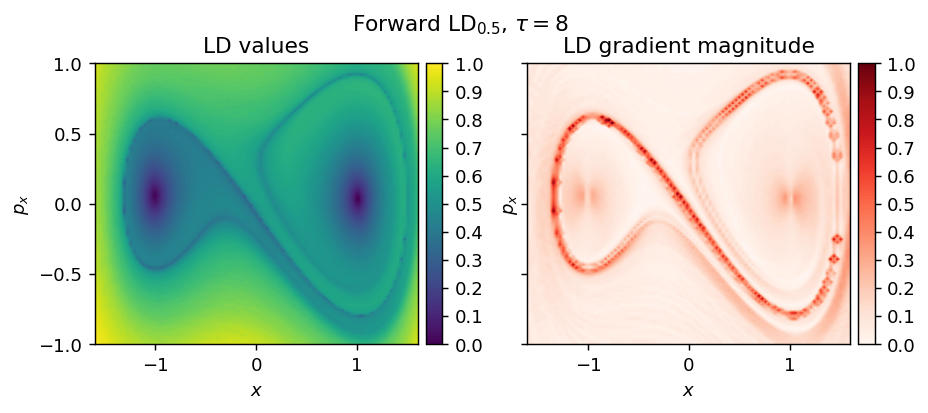

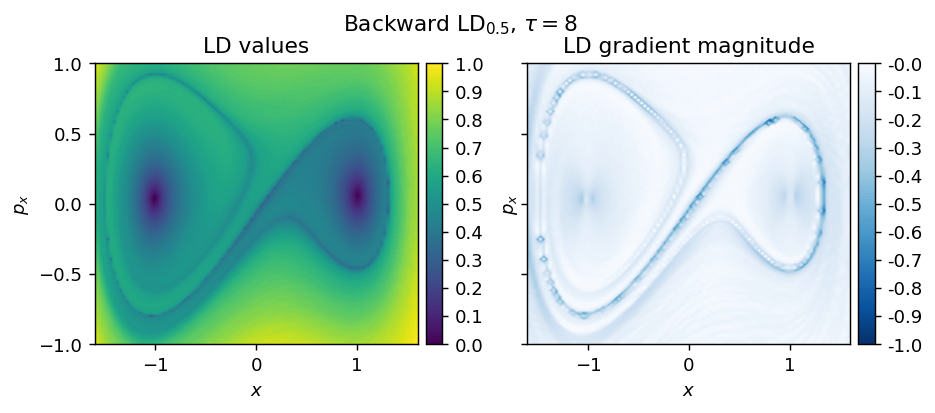

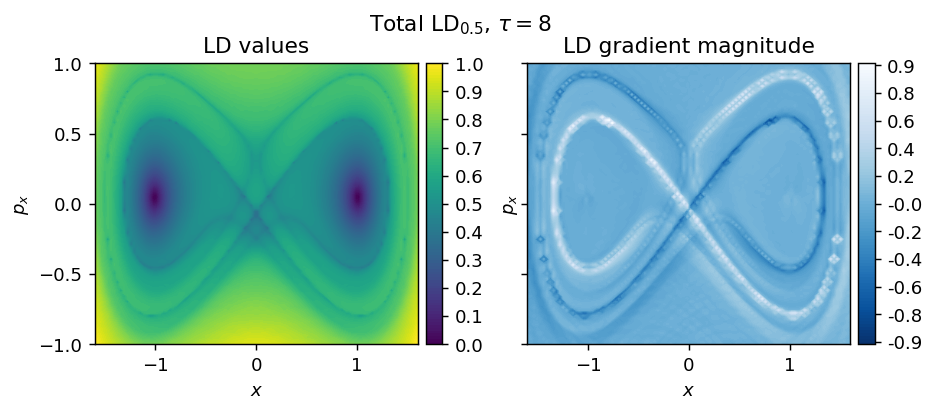

In [10]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, discretised_vector_field, tau, p_value)
LD_backward = compute_lagrangian_descriptor(grid_parameters, discretised_vector_field, -tau, p_value)
figs = draw_all_lds(LD_forward, LD_backward, grid_parameters, tau, p_value, interactive=False)

# APPENDIX

Plot vector field with arrows

TypeError: Length of x (21) must match number of columns in z (15)

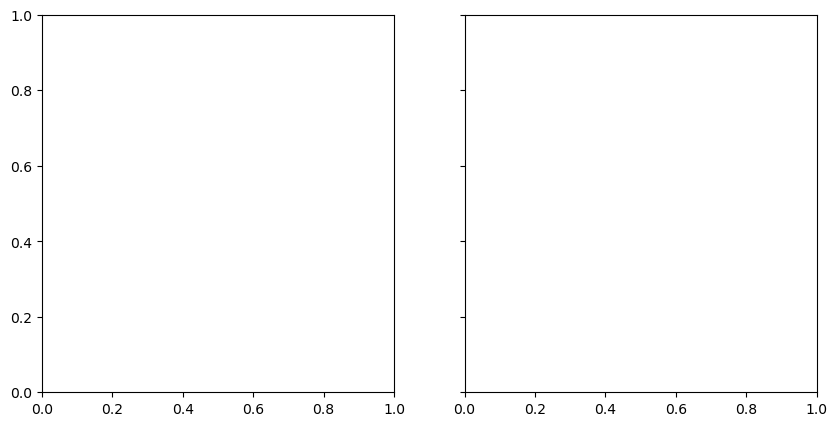

In [40]:
fig,ax = plt.subplots(1,2,figsize=(10,5) ,dpi=100, sharex=True, sharey=True)

C = np.linalg.norm(vector_field_frames[0],axis=1)
u, v = vector_field_frames[0].T
ax[0].contourf(x, y, C.reshape(len(x), len(y)),cmap='jet',levels=20)
ax[0].quiver(points.T[0], points.T[1], u, v, zorder=100)

C = np.linalg.norm(vector_field_frames[10],axis=1)
u, v = vector_field_frames[10].T
ax[1].contourf(x, y, C.reshape(len(x), len(y)),cmap='jet',levels=20)
ax[1].quiver(points.T[0], points.T[1], u, v, zorder=100)

plt.show()

SANITY TEST about precision

In [43]:
for t0 in np.linspace(t_min, t_max, 6):
    test = (vector_field(t0, points).T == vector_field_interp(t0)).all()
    diff = vector_field(t0, points).T - vector_field_interp(t0)
    print(t0, test, diff.min(), diff.max())

0.0 True 0.0 0.0
2.0 False -8.881784197001252e-16 8.881784197001252e-16
4.0 False -8.881784197001252e-16 4.440892098500626e-16
6.0 False -8.881784197001252e-16 2.220446049250313e-16
8.0 False -4.440892098500626e-16 8.881784197001252e-16
10.0 True 0.0 0.0
